# Домашнее задание - NN1 | Василенко Егор

## Введение (Intro)

### Условие задания

В рамках этого соревнования стоит две задачи:
1. Написать и обучить самописную архитектуру модели на pytorch
2. Получить высокий score на финальном leaderboard

### Итоговое место в соревновании

### Загрузка необходимых библиотек

### Импорт библиотек и дополнительные настройки

In [15]:
# Стандартные библиотеки
import os
import re
import sys
import pymorphy3
import warnings
import nltk
import math
from IPython.display import display

# База
import pandas as pd
import numpy as np
from scipy.sparse import hstack

# ML/NN
import random
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, Trainer, TrainingArguments)
import datasets
from datasets import Dataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from razdel import tokenize as rz_tok

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk
from wordcloud import WordCloud

# Корреляция и логика пропусков
from phik import phik_matrix
import missingno as msno

# Настройки стиля визуализации и игнора продупреждений
plt.style.use('cyberpunk')
warnings.filterwarnings('ignore')

# Воспроизводимость
RANDOM_STATE = 42

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Загрузка данных

In [3]:
train = pd.read_csv('/kaggle/input/neural-networks-1-homework/train.csv')

test = pd.read_csv('/kaggle/input/neural-networks-1-homework/test.csv')

## EDA-анализ

In [ ]:
datasets = {'train': train,
            'test': test}

### Общая информация

In [ ]:
for name, dataset in datasets.items():
  print(f"Информация о датасете {name}:")
  print("===============================================================")
  display(dataset.info())
  display(dataset.describe())
  display(dataset.head())
  print("===============================================================")

Информация о датасете train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16667 entries, 0 to 16666
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            16667 non-null  object 
 1   location         16667 non-null  object 
 2   company          16667 non-null  object 
 3   skills           10842 non-null  object 
 4   description      16667 non-null  object 
 5   experience_from  16667 non-null  float64
 6   salary_from      16667 non-null  float64
 7   log_salary_from  16667 non-null  float64
dtypes: float64(3), object(5)
memory usage: 1.0+ MB


None

,experience_from,salary_from,log_salary_from
count,16667.000000,16667.000000,16667.000000
mean,1.510680,111.980052,4.516523
std,1.355363,77.474035,0.629785
min,0.000000,5.100000,1.629241
25%,1.000000,60.000000,4.094345
50%,1.000000,90.000000,4.499810
75%,3.000000,150.000000,5.010635
max,10.000000,1000.000000,6.907755


,title,location,company,skills,description,experience_from,salary_from,log_salary_from
0,Специалист технической поддержки,Воронеж,ВКТМ,NaN,Обязанности: Обеспечение бесперебойной раб...,1.0,60.0,4.094345
1,Product Owner в ИТ-стартап (B2C),Москва,Radium Finance,"CustDev, Стратегический менеджмент, Управление...","Эта вакансия про тебя, если симбиоз управленче...",6.0,200.0,5.298317
2,Системный администратор ( Клинический Госпитал...,Москва,Медскан,NaN,АО «Медскан» – динамично развивающаяся группа ...,1.0,130.0,4.867534
3,Системный Администратор Linux,Москва,Selecty,"Linux, PostgreSQL",Задачи: Администрирование инфраструктуры н...,3.0,170.0,5.135798
4,Начальник участка общестроительных работ,Пушкино (Московская область),NK GROUP,NaN,NK Group – ведущий девелопер индустриальных о...,3.0,200.0,5.298317


Информация о датасете test:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5556 entries, 0 to 5555
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            5556 non-null   object 
 1   location         5556 non-null   object 
 2   company          5556 non-null   object 
 3   skills           3542 non-null   object 
 4   description      5556 non-null   object 
 5   experience_from  5556 non-null   float64
dtypes: float64(1), object(5)
memory usage: 260.6+ KB


None

,experience_from
count,5556.000000
mean,1.522498
std,1.348813
min,0.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,10.000000


,title,location,company,skills,description,experience_from
0,Ведущий программист 1С (г. Санкт-Петербург),Санкт-Петербург,Коннект персонал,"1С программирование, MS SQL Server, 1C: ERP, О...",Крупнейший производственный комплекс легкой пр...,3.0
1,Ресерчер (поиск товаров на маркетплейсах),Москва,Right Choice,"Конкурентная аналитика, Аналитические исследов...","Мы молодая команда селлеров, состоящая из 12 ч...",1.0
2,Системный администратор,Нижний Новгород,Меридиан,"Администрирование сетевого оборудования, Админ...",О компании: Уже более 30 лет мы успешно прои...,1.0
3,Инженер по интеграции систем защиты информации,Новосибирск,СофтМолл,"Информационная безопасность, Аналитическое мыш...","SoftMall – это аккредитованная IT-компания, к...",1.0
4,Ведущий менеджер по работе с маркетплейсом Wil...,Москва,ДЖЕЙКЕТ РАБОТА,NaN,Вакансия компании: Brosco Компания Brosco зан...,1.0


**Вывод:**
- Пропуски присутствуют лишь в столбце `skills` - стоит подумать над обработкой, хотя, возможно, модели будут полезны и примеры с пропусками по навыкам;
- Данные в обоих датасетах соответсвуют корректным форматам данных.

### Распределения и выбросы

In [ ]:
# Числовые столбцы, за исключение таргета
num_cols = train.select_dtypes(include=['int64', 'float64']).columns

# Категориальные столбцы
cat_cols = train.select_dtypes(include=['object', 'category']).columns

Столбец salary_from есть в train, но отсутствует в test — рисую только train
Столбец log_salary_from есть в train, но отсутствует в test — рисую только train


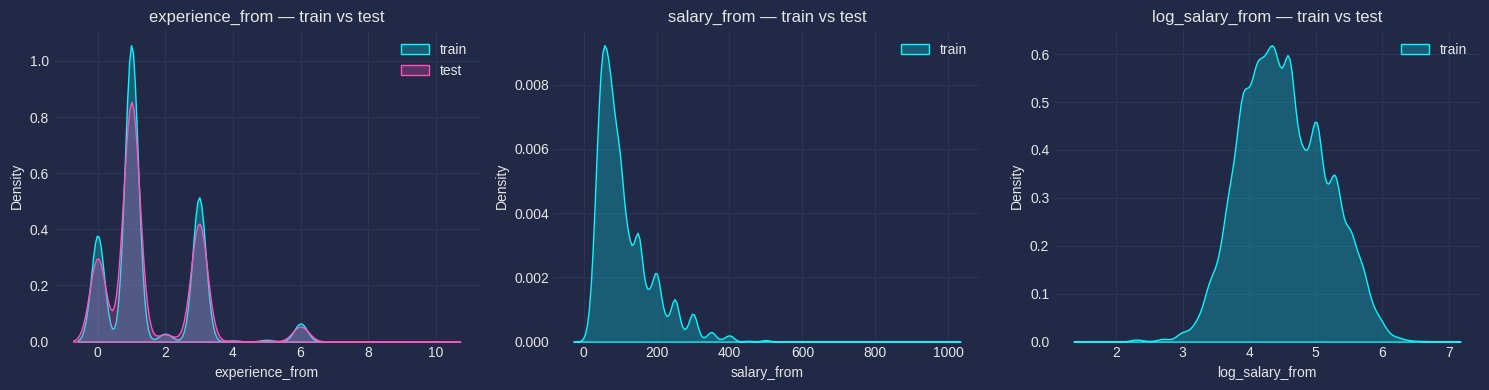

In [ ]:
n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

plot_idx = 0

for col in num_cols:
    # Рисуем только для тех колонок, что есть в train
    if col not in train.columns:
        continue

    sns.kdeplot(train[col], label='train', fill=True, ax=axes[plot_idx])

    # А вот test — только если в нём есть этот столбец
    if col in test.columns:
        sns.kdeplot(test[col], label='test', fill=True, ax=axes[plot_idx])
    else:
        print(f"Столбец {col} есть в train, но отсутствует в test — рисую только train")

    axes[plot_idx].set_title(f'{col} — train vs test')
    axes[plot_idx].legend()
    plot_idx += 1

# Удаляем пустые оси, если они остались
for j in range(plot_idx, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Вывод:**
- Распределения по столбцу `experience_from` приблизительно совпадают в `train` и `test`;
- Логарифмированная зарплата `log_salary_from` является целевой переменной и в преобразованной форме приближается к нормальному распределению.

In [ ]:
outliers_stats = []

for col in num_cols:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = train[(train[col] < lower) | (train[col] > upper)]
    num_outliers = len(outliers)
    total = train[col].notna().sum()
    percent = 100 * num_outliers / total if total > 0 else 0

    outliers_stats.append({
        'column': col,
        'num_outliers': num_outliers,
        'total': total,
        'percent': percent
    })

outliers_df = pd.DataFrame(outliers_stats).sort_values('percent', ascending=False).reset_index(drop=True)

styled_df = outliers_df.style.background_gradient(subset=['num_outliers', 'percent'], cmap='Reds')

display(styled_df)

,column,num_outliers,total,percent
0,salary_from,728,16667,4.367913
1,log_salary_from,53,16667,0.317994
2,experience_from,10,16667,0.059999


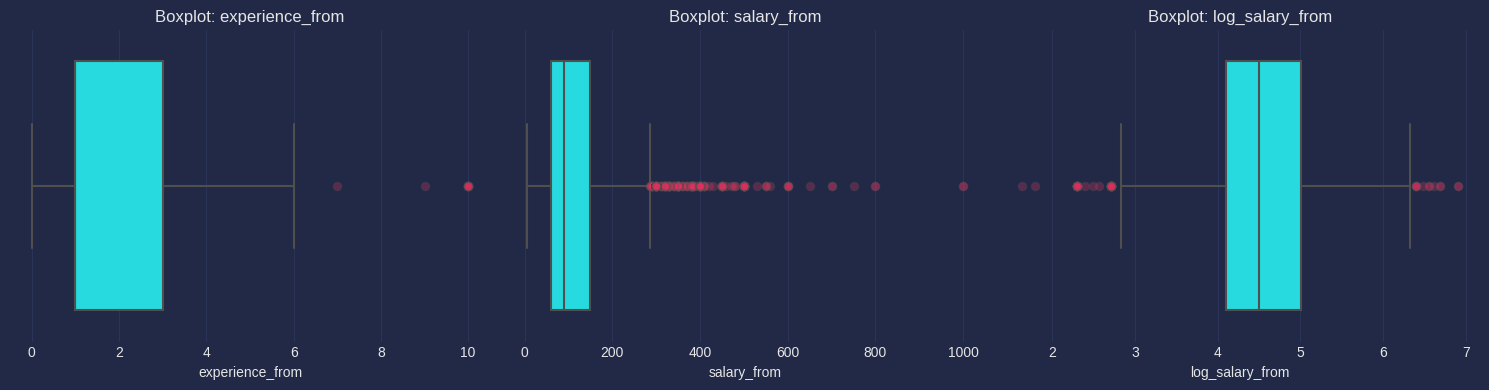

In [ ]:
n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols  # округляем вверх

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x=train[col], ax=axes[i], flierprops=dict(marker='o', markerfacecolor='#DE3163', markersize=6, linestyle='none', alpha=0.3))
    axes[i].set_title(f'Boxplot: {col}')

# Отключим лишние пустые подграфики
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Вывод:**
- Доля выбросов минимальна, при этом при логарифмировании зарлпаты их доля по этому столбцу сокращается с 4.37% до 0.32%;
- Доля выбросов по столбцу `experience_from` составляет ещё более меньшие 0.06%;
- Пропуски можно либо обработать (например, удалить), либо оставить так, как есть, ибо очень малое количество вряд-ли значительно повлияет на результат.

### Анализ пропусков

In [ ]:
for name, dataset in datasets.items():
    print(f"Количество пропусков в абсолютных и относительных значениях в {name}:")
    display(pd.DataFrame({
    'Total NaN': dataset.isna().sum(),
    'Percentage NaN': dataset.isna().mean() * 100
    }).style.background_gradient('coolwarm').format({'Percentage NaN': '{:.2f}%'}))

Количество пропусков в абсолютных и относительных значениях в train:


,Total NaN,Percentage NaN
title,0,0.00%
location,0,0.00%
company,0,0.00%
skills,5825,34.95%
description,0,0.00%
experience_from,0,0.00%
salary_from,0,0.00%
log_salary_from,0,0.00%


Количество пропусков в абсолютных и относительных значениях в test:


,Total NaN,Percentage NaN
title,0,0.00%
location,0,0.00%
company,0,0.00%
skills,2014,36.25%
description,0,0.00%
experience_from,0,0.00%


**Вывод:**
- Доля пропусков в `train` = 34.95%;
- Доля пропусков в `test` = 36.25%.

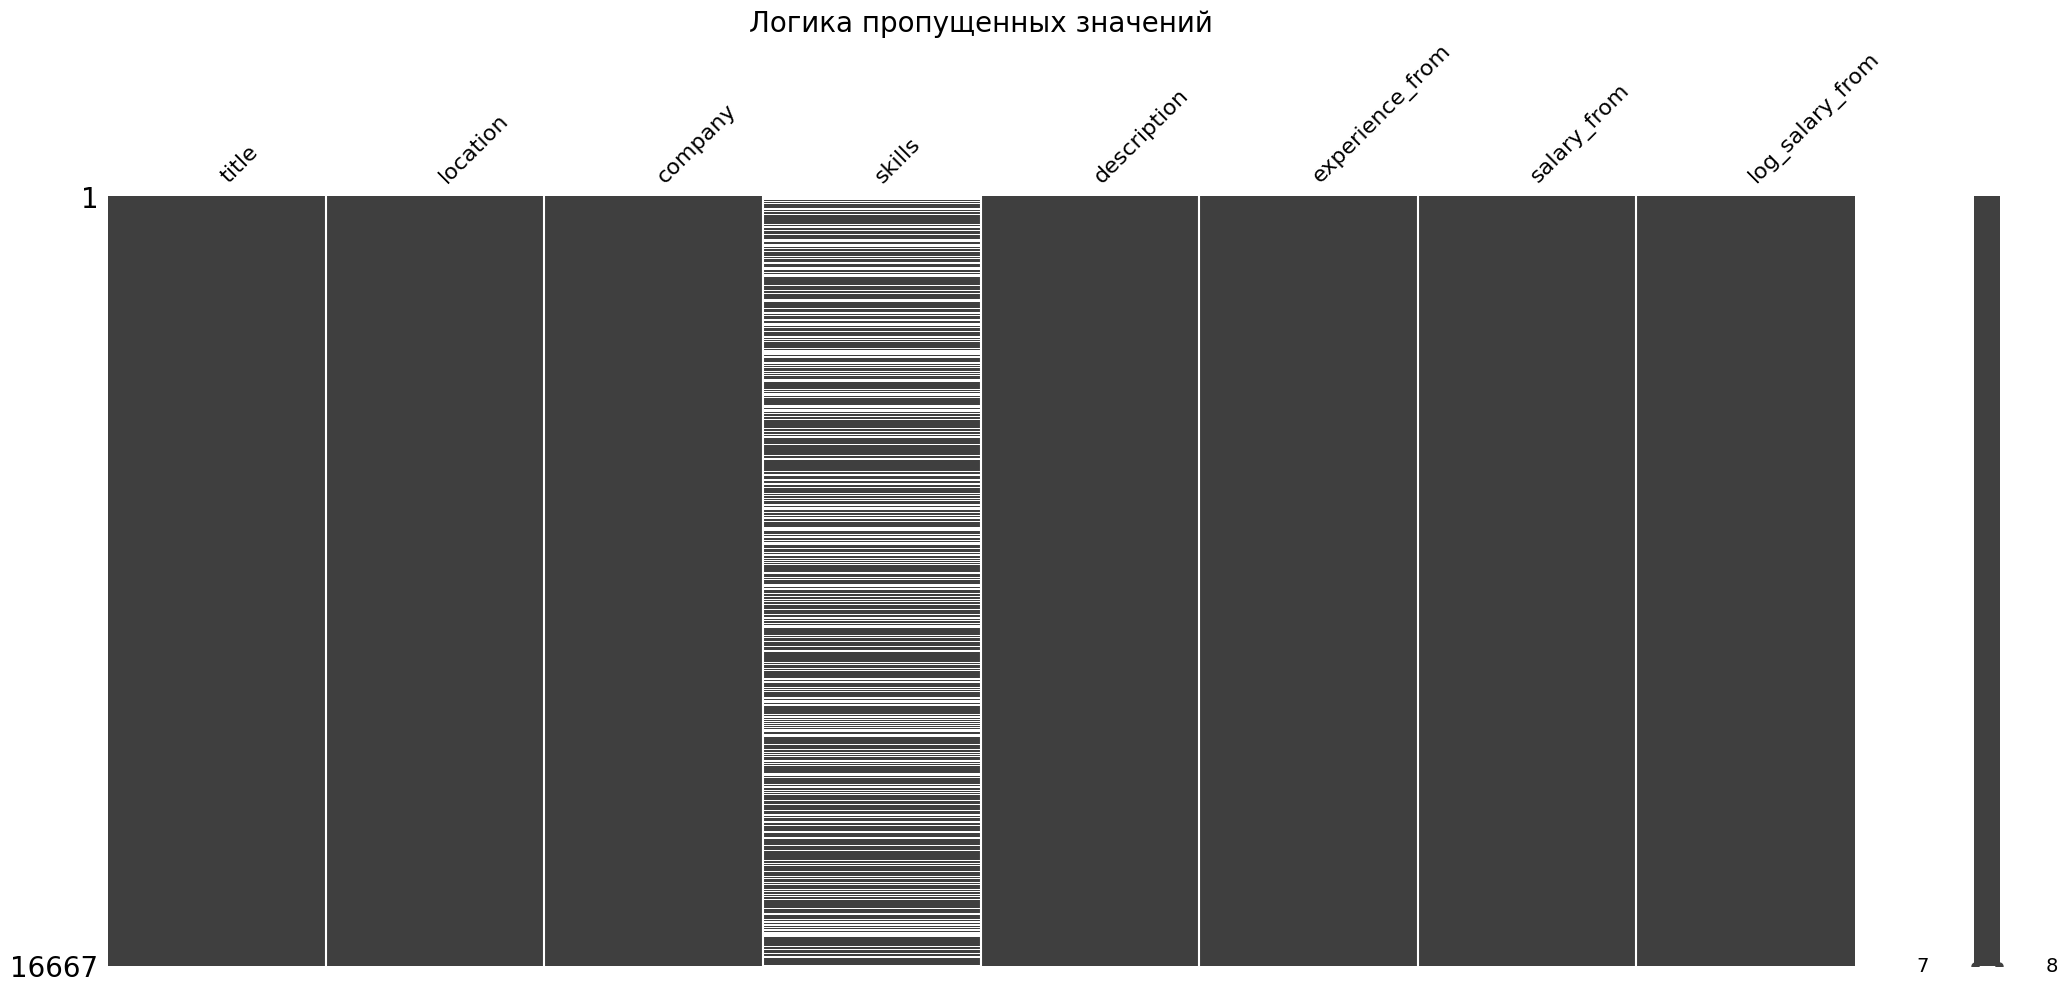

In [ ]:
with plt.style.context('default'):
    msno.matrix(train)
    plt.title("Логика пропущенных значений", fontsize=20)
    plt.tight_layout()
    plt.show()

**Вывод:**
- В данном контексте конкретных выводов сделать не получится.

### Анализ дубликатов

#### Явные дубликаты

In [ ]:
for name, dataset in datasets.items():
    print(f"В датасете {name} {dataset.duplicated().sum()} явных дубликатов.")

В датасете train 0 явных дубликатов.
В датасете test 0 явных дубликатов.


#### Неявные дубликаты (?)

Решил, что это ресурсно затратно и условные трансформеры наоборот лучше научятся понимать контекст с условными ошибками*.

### Анализ корреляции

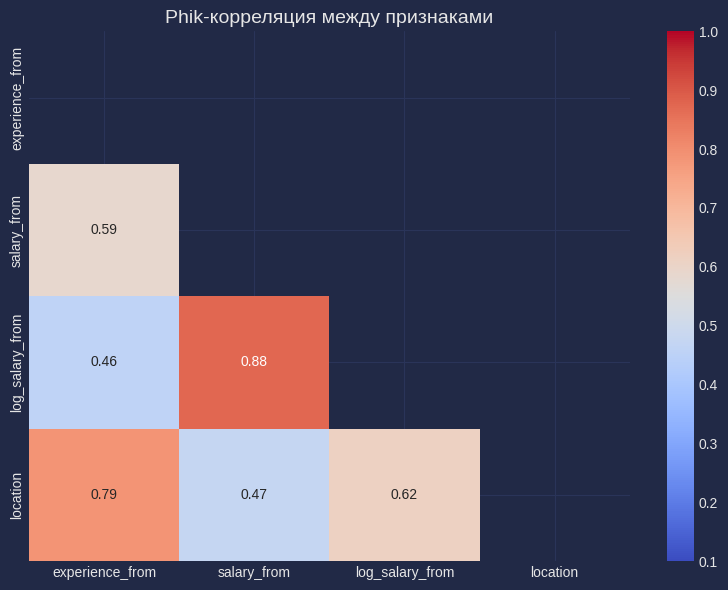

In [ ]:
# Явно задаём интервальные колонки
interval_cols = ['experience_from', 'salary_from', 'log_salary_from']

# Оставляем только нужные поля: интервальные + легкую категорию (location)
cols_for_phik = interval_cols + ['location']

df_small = train[cols_for_phik].copy()

# Вычисляем PHIK‑матрицу без параллелизма (чтобы не плодить воркеры)
phik_corr = df_small.phik_matrix(
    interval_cols=interval_cols
)

# Фильтруем и строим теплокарту
mask = np.triu(np.ones_like(phik_corr, dtype=bool))
phik_corr_filtered = phik_corr.copy()
phik_corr_filtered[phik_corr_filtered < 0.1] = np.nan

plt.figure(figsize=(8, 6))
sns.heatmap(
    phik_corr_filtered,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    vmin=0.1,
    vmax=1
)
plt.title("Phik‑корреляция между признаками", fontsize=14)
plt.tight_layout()
plt.show()

**Вывод:**
1. **Очень сильная связь между `salary_from` и `log_salary_from` (φ ≈ 0.88)**  
   Логарифмическое преобразование сохраняет порядок значений, поэтому эти поля оказываются почти полностью взаимозаменяемыми в бинарном разделении на «высокие» и «нзкие» зарплаты. Теоретически можно обойтись только `log_salary_from` в качестве целевой переменной.
2. **Умеренная связь между `experience_from` и `salary_from` (φ ≈ 0.59) и между `experience_from` и `log_salary_from` (φ ≈ 0.46)**  
   Связь опыта с уровнем зарплаты есть, но она не доминирующая. Возможно включить `experience_from` в качестве числового признака для нейросети, при этом стоит рассмотреть масштабирование или нормализацию этого признака.
3. **Значимая связь между `location` и `experience_from` (φ ≈ 0.79), а также между `location` и `log_salary_from` (φ ≈ 0.62)**  
   Географический регион может оказывать влияние на требования к опыту и уровень зарплаты. Теоретически представление `location` через обучаемый embedding позволяет сети самостоятельно выявить эти региональные зависимости.

In [ ]:
num_cols_with_target = train.select_dtypes(include=['int64', 'float64']).columns

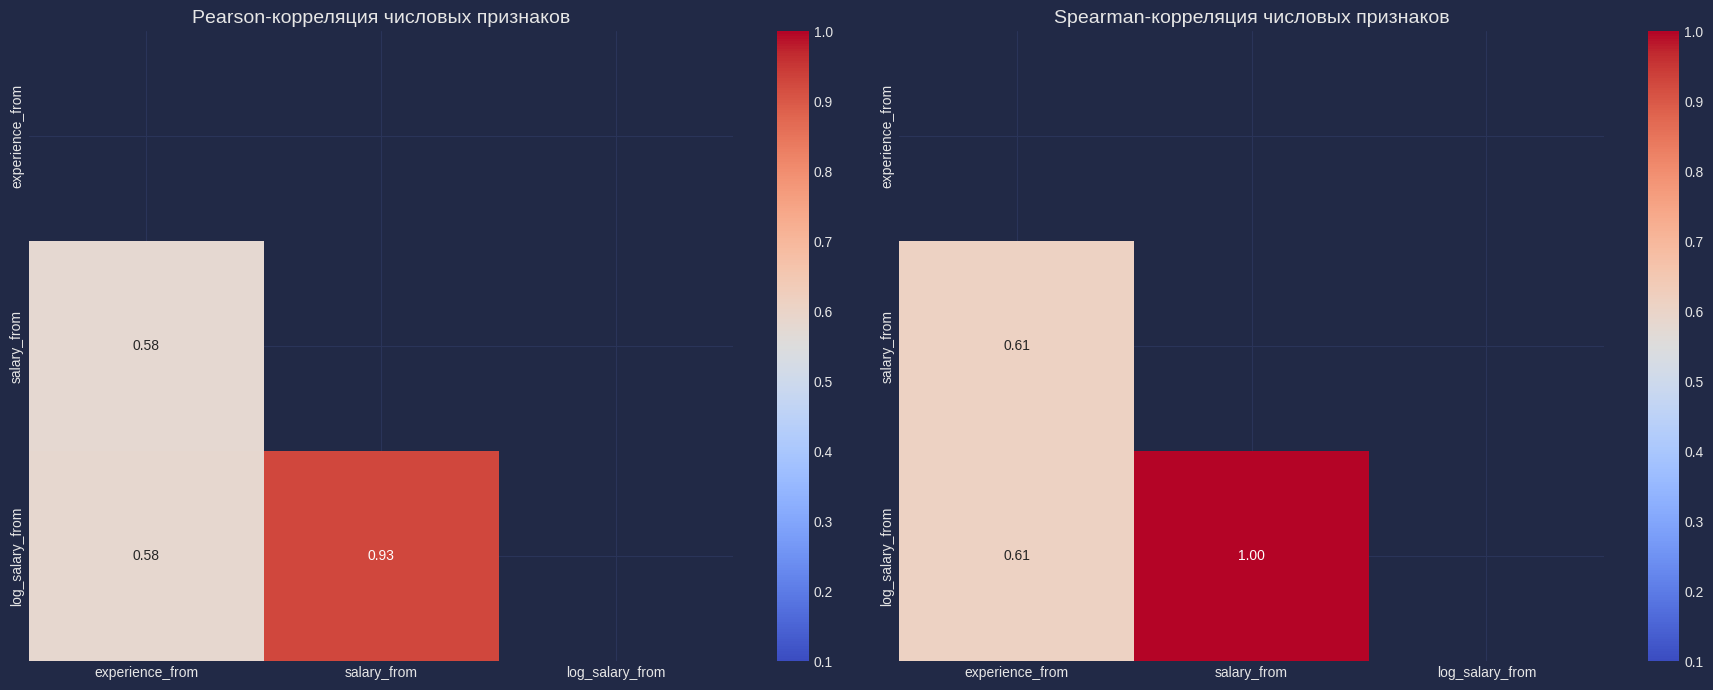

In [ ]:
# Pearson-корреляция
corr_pearson = train[num_cols_with_target].corr(method='pearson')
mask_pearson = np.triu(np.ones_like(corr_pearson, dtype=bool))
corr_pearson_filtered = corr_pearson.copy()
corr_pearson_filtered[abs(corr_pearson_filtered) < 0.1] = np.nan

# Spearman-корреляция
corr_spearman = train[num_cols_with_target].corr(method='spearman')
mask_spearman = np.triu(np.ones_like(corr_spearman, dtype=bool))
corr_spearman_filtered = corr_spearman.copy()
corr_spearman_filtered[abs(corr_spearman_filtered) < 0.1] = np.nan

# Визуализация двумя сабплотами
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(corr_pearson_filtered, mask=mask_pearson, annot=True, fmt='.2f',
            cmap='coolwarm', vmin=0.1, vmax=1, ax=axes[0])
axes[0].set_title("Pearson-корреляция числовых признаков", fontsize=14)

sns.heatmap(corr_spearman_filtered, mask=mask_spearman, annot=True, fmt='.2f',
            cmap='coolwarm', vmin=0.1, vmax=1, ax=axes[1])
axes[1].set_title("Spearman-корреляция числовых признаков", fontsize=14)

plt.tight_layout()
plt.show()

**Вывод:**
- **Опыт и зарплата (`experience_from` vs `salary_from`)**  
  Pearson ≈ 0.58, Spearman ≈ 0.61  
  Умеренная линейная и порядковая связь указывает на общую тенденцию к росту зарплаты с увеличением опыта, хотя разброс значителен.
- **Опыт и логарифм зарплаты (`experience_from` vs `log_salary_from`)**  
  Pearson ≈ 0.58, Spearman = 1.00  
  Порядковая связь является идеальной, поскольку логарифмическое преобразование сохраняет ранжирование. Это может теоретически улучшить распределение ошибок при использовании MSE‑лосса.
- **Зарплата и её логарифм (`salary_from` vs `log_salary_from`)**  
  Pearson ≈ 0.93, Spearman = 1.00  
  Сильная линейная и идеальная порядковая связь показывает, что `log_salary_from` служит хорошей трансформацией исходного таргета.

**Теоретические рекомендации:**  
- Можно использовать `log_salary_from` в качестве единственной целевой переменной.  
- Возможно передать `experience_from` напрямую (с обязательным масштабированием или нормализацией).  
- Для `location` теоретически оправдано обучение отдельного embedding‑слоя, чтобы сеть могла адаптивно моделировать влияние региона.

#### Проверим логарифмированный столбец на сопадение

In [ ]:
mask = np.isclose(np.log(train['salary_from']), train['log_salary_from'])
print("Совпадает:", mask.mean()*100, "% строк")

Совпадает: 100.0 % строк


## Самописный вариант трансформера

### Токенайзер

In [4]:
class SimpleTokenizer:
    """
    Самописный токенайзер.

    Основное назначение:
      - превратить сырой текст в упорядоченную последовательность целых индексов;
      - сократить словарь, откинув редкие токены, тем самым уменьшая память и шум;
      - сформировать attention‑mask, чтобы модель игнорировала паддинги.

    Методы:
      build_vocab(texts) - строит словарь по частотам (учитывает min_freq);
      encode(text) - кодирует одну строку в dict{'input_ids','attention_mask'} длины max_len;
      batch_encode(texts) - пакетно кодирует список строк, удобен для DataLoader.

    Атрибуты после build_vocab:
      itos - список индексов -> токены (index to string);
      stoi - словарь токен -> индекс (string to index).
    """
    PAD_TOKEN = '[PAD]'
    UNK_TOKEN = '[UNK]'

    def __init__(self, min_freq=2, max_len=128):
        """
        min_freq - минимальная частота токена, чтобы попасть в словарь;
        max_len - итоговая длина выходной последовательности (длинные строки обрезаются, короткие паддятся).
        """
        self.min_freq = min_freq
        self.max_len = max_len
        self.itos = []
        self.stoi = {}

    @staticmethod
    def _basic_tokenize(text):
        """
        Делит строку text на список токенов:
          - \w+  : группы букв/цифр (слова, числа)
          - [^\w\s] : одиночные непробельные символы (пунктуация)
        Регистр приводится к нижнему.
        """
        return re.findall(r"\w+|[^\w\s]", text.lower(), re.UNICODE)

    def build_vocab(self, texts):
        """
        Строит словарь по списку строк texts.
        Сначала считает частоты токенов, затем:
          - добавляет [PAD] и [UNK] в начало;
          - оставляет токены с freq >= min_freq;
          - формирует itos и stoi.
        """
        from collections import Counter
        cnt = Counter()
        for t in texts:
            cnt.update(self._basic_tokenize(t))
        self.itos = [self.PAD_TOKEN, self.UNK_TOKEN] + [
            w for w, f in cnt.items() if f >= self.min_freq
        ]
        self.stoi = {w: i for i, w in enumerate(self.itos)}

    def encode(self, text):
        """
        Кодирует одну строку:
          1) токенизация
          2) замена токенов на индексы (OOV -> [UNK])
          3) усечение/дополнение do max_len
          4) формирование attention_mask
        Возвращает dict{'input_ids','attention_mask'}.
        """
        toks = self._basic_tokenize(text)
        ids = [self.stoi.get(t, self.stoi[self.UNK_TOKEN]) for t in toks][: self.max_len]
        pad_len = self.max_len - len(ids)
        if pad_len:
            ids += [self.stoi[self.PAD_TOKEN]] * pad_len
        mask = [0 if idx == self.stoi[self.PAD_TOKEN] else 1 for idx in ids]
        return {"input_ids": ids, "attention_mask": mask}

    def batch_encode(self, texts):
        """
        Пакетно кодирует список строк texts.
        Используется DataLoader‑ом, когда он передаёт список индексов.
        Возвращает dict с двумя списками списков одинаковой длины max_len.
        """
        ids_batch, mask_batch = [], []
        for t in texts:
            enc = self.encode(t)
            ids_batch.append(enc["input_ids"])
            mask_batch.append(enc["attention_mask"])
        return {"input_ids": ids_batch, "attention_mask": mask_batch}

### Обёртка данных в PyTorch формат

In [10]:
class JobsDataset(Dataset):
    """
    Dataset для вакансий. Возвращает словарь с полями:
      - input_ids: tensor длиной max_len
      - attention_mask: tensor длиной max_len (1 для реальных токенов, 0 для PAD)
      - labels: tensor-метка (float)
    
    Поддерживает:
      - __getitem__(int) -> один пример
      - __getitem__([int,...]) -> батч примеров
    """

    def __init__(self,
                 texts: pd.Series,
                 targets: np.ndarray,
                 tokenizer: SimpleTokenizer):
        """
        texts: pd.Series строк полного текста вакансии
        targets: numpy.ndarray вещественных целевых значений (log_salary_from)
        tokenizer: экземпляр SimpleTokenizer
        """
        self.texts = texts.tolist()
        self.labels = targets.astype(np.float32)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # если idx — список или массив индексов, батчим сразу несколько примеров
        if isinstance(idx, (list, tuple, np.ndarray)):
            batch_texts = [self.texts[i] for i in idx]
            batch_labels = [self.labels[i] for i in idx]
            enc = self.tokenizer.batch_encode(batch_texts)
            return {
                "input_ids": torch.tensor(enc["input_ids"], dtype=torch.long),
                "attention_mask": torch.tensor(enc["attention_mask"], dtype=torch.long),
                "labels": torch.tensor(batch_labels, dtype=torch.float),
            }

        # одиночный пример
        enc = self.tokenizer.encode(self.texts[idx])
        return {
            "input_ids": torch.tensor(enc["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(enc["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(self.labels[idx], dtype=torch.float),
        }

### Компоненты Encoder‑части Transformer

In [11]:
class SinusoidalPositionalEncoding(nn.Module):
    """
    Синусоидальные позиционные коды (Vaswani et al., 2017).
    PE(pos, 2i)   = sin(pos / 10000^(2i / d_model))
    PE(pos, 2i+1) = cos(pos / 10000^(2i / d_model))

    Назначение:
    - добавить информацию о позиции токена к его эмбеддингу, чтобы self‑attention мог учитывать порядок без рекуррентности.

    forward(x):
      x - тензор [B,L,D] после слоя Embedding;
      возвращает x + pe[0:L], где pe не обучается, хранится в буфере.
    """
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe)  # не обучается, но идёт в state_dict

    def forward(self, x):
        """Добавляет позиционное кодирование к первым L токенам входа x."""
        return x + self.pe[: x.size(1)].unsqueeze(0)

class MultiHeadSelfAttention(nn.Module):
    """
    Многоголовое self‑attention (scaled dot‑product).

    Параметры:
    - d_model  - размерность скрытого пространства
    - num_heads - количество «голов» (под‑пространств)
    - dropout  - dropout на softmax(attention)

    forward(x,mask):
      x - [B,L,D]; mask - [B,1,1,L] (0 для PAD)
      вывод - контекст той же формы [B,L,D]
    """
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model % num_heads != 0"
        self.d_head = d_model // num_heads
        self.num_heads = num_heads
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        """
        1) Q,K,V проекции и разбиение на головы
        2) scaled dot‑product attention с маской PAD
        3) склейка голов и финальная проекция
        """
        B, L, _ = x.shape
        q = self.w_q(x).view(B, L, self.num_heads, self.d_head).transpose(1, 2)
        k = self.w_k(x).view(B, L, self.num_heads, self.d_head).transpose(1, 2)
        v = self.w_v(x).view(B, L, self.num_heads, self.d_head).transpose(1, 2)
        scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.d_head)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-1e9"))
        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        ctx = attn @ v
        ctx = ctx.transpose(1, 2).contiguous().view(B, L, -1)
        return self.w_o(ctx)

class PositionwiseFFN(nn.Module):
    """
    Позиционно‑независимый FFN (два линейных слоя + GELU + Dropout).

    forward(x) возвращает трансформированные представления той же формы.
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )

    def forward(self, x):
        return self.net(x)

class EncoderBlock(nn.Module):
    """
    Один слой энкодера:
      x -> LN(x + Dropout(SelfAttention(x)))
        -> LN(x + Dropout(FFN(x)))

    Сохраняет размерность, добавляет residual, LayerNorm, Dropout.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadSelfAttention(d_model, num_heads, dropout)
        self.ln1 = nn.LayerNorm(d_model)
        self.ffn = PositionwiseFFN(d_model, d_ff, dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = self.ln1(x + self.drop(self.attn(x, mask)))
        x = self.ln2(x + self.drop(self.ffn(x)))
        return x

class TinyTransformerRegressor(nn.Module):
    """
    Лёгкий Transformer‑регрессор для предсказания одного скалярного значения.

    Архитектура:
      Embedding -> PosEncoding -> N*EncoderBlock
      -> MeanPooling (mask) -> Dropout -> Linear(d_model->1)

    forward(input_ids, attention_mask) выводит тензор[B] с прогнозом.
    """
    def __init__(self, vocab_size, d_model=256, num_heads=4, d_ff=512,
                 num_layers=2, max_len=512, dropout=0.1):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos = SinusoidalPositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList(
            [EncoderBlock(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)]
        )
        self.head = nn.Linear(d_model, 1)
        self.drop = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask=None):
        """
        input_ids[B,L] - индексы словаря
        attention_mask[B,L] - 1 для реальных токенов, 0 для PAD
        Возвращает тензор[B] с предсказанием (log_salary_from).
        """
        if attention_mask is None:
            attention_mask = (input_ids != 0).long()
        mask = attention_mask.unsqueeze(1).unsqueeze(2)
        h = self.pos(self.emb(input_ids))
        for layer in self.layers:
            h = layer(h, mask)
        lengths = attention_mask.sum(1).clamp(min=1).unsqueeze(-1)
        pooled = (h * attention_mask.unsqueeze(-1)).sum(1) / lengths
        return self.head(self.drop(pooled)).squeeze(-1)

### Предобработка

In [12]:
# Подготовка данных, датасеты, загрузчики
df_6 = train.copy()
text_cols = ["title", "location", "company", "skills", "description"]
df_6[text_cols] = df_6[text_cols].fillna("")
df_6["full_text"] = df_6[text_cols].agg(" ".join, axis=1)

max_len = 128
tokenizer = SimpleTokenizer(min_freq=2, max_len=max_len)
tokenizer.build_vocab(df_6["full_text"].tolist())

tr_texts, val_texts, y_tr, y_val = train_test_split(
    df_6["full_text"], df_6["log_salary_from"], test_size=0.25, random_state=42
)
train_ds = JobsDataset(tr_texts, y_tr.values, tokenizer)
val_ds = JobsDataset(val_texts, y_val.values, tokenizer)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=2)

### Облако токенов самописного токенайзера

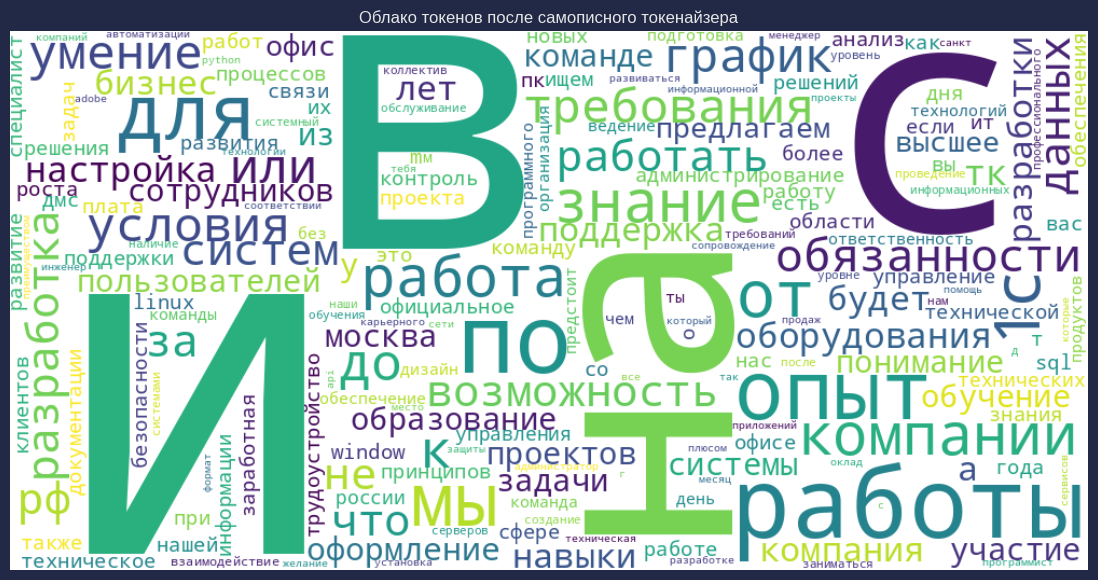

In [16]:
# Собираем все токены из полного текста через ваш токенайзер
all_tokens = []
for text in df_6["full_text"]:
    toks = tokenizer._basic_tokenize(text)   # тот же метод, что в классе
    all_tokens.extend(toks)

# Если токены есть — строим облако
if all_tokens:
    wc = WordCloud(
        width=1000,
        height=500,
        background_color="white",
        collocations=False
    ).generate(" ".join(all_tokens))

    plt.figure(figsize=(15, 7))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Облако токенов после самописного токенайзера")
    plt.show()
else:
    print("Недостаточно токенов для построения облака.")

### Инициализация и обучение модели

In [13]:
# Инициализация модели, оптимизатор, loss и scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyTransformerRegressor(
    vocab_size=len(tokenizer.itos),
    d_model=256,
    num_heads=4,
    d_ff=512,
    num_layers=2,
    max_len=max_len,
    dropout=0.1,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
loss_fn = nn.MSELoss()

In [14]:
# Обучение и валидация
for epoch in range(1, 11):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        preds = model(input_ids, attention_mask)
        loss = loss_fn(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * input_ids.size(0)

    print(f"Epoch {epoch:02d} Train MSE: {total_loss / len(train_ds):.4f}")

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            preds = model(input_ids, attention_mask)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    preds = np.concatenate(all_preds)
    gold = np.concatenate(all_labels)
    val_r2 = r2_score(gold, preds)

    print(f"Epoch {epoch:02d} Val   R²: {val_r2:.4f}")

    scheduler.step()

Epoch 01 Train MSE: 0.6434
Epoch 01 Val   R²: 0.3879
Epoch 02 Train MSE: 0.2078
Epoch 02 Val   R²: 0.5665
Epoch 03 Train MSE: 0.1668
Epoch 03 Val   R²: 0.5608
Epoch 04 Train MSE: 0.1467
Epoch 04 Val   R²: 0.6011
Epoch 05 Train MSE: 0.1320
Epoch 05 Val   R²: 0.5963
Epoch 06 Train MSE: 0.1124
Epoch 06 Val   R²: 0.6077
Epoch 07 Train MSE: 0.1012
Epoch 07 Val   R²: 0.5810
Epoch 08 Train MSE: 0.0948
Epoch 08 Val   R²: 0.5960
Epoch 09 Train MSE: 0.0856
Epoch 09 Val   R²: 0.5884
Epoch 10 Train MSE: 0.0775
Epoch 10 Val   R²: 0.6029


## Вариант с линейной моделью

Вариант линейной модели, который практически идентичен тому, что было на практике одного из занятий.

### Предобработка

In [17]:
train_df = train.copy()
test_df = test.copy()

In [18]:
txt_cols = ['title', 'location', 'company', 'skills', 'description']
for df in (train_df, test_df):
    df[txt_cols] = df[txt_cols].fillna('') # убираем NaN
    df[txt_cols] = df[txt_cols].astype(str) # приводим к str
    df['full_text'] = df[txt_cols].agg(' '.join, axis=1)

train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=RANDOM_STATE)

In [19]:
nltk.download('stopwords', quiet=True)
raw_stop = set(nltk.corpus.stopwords.words('russian'))
raw_stop.update(['наш','компания','команда','работа','вакансия','искать'])

morph = pymorphy3.MorphAnalyzer()
stop_words = {morph.parse(w)[0].normal_form for w in raw_stop} # лемматизируем стоп‑слова

In [20]:
def analyzer(text):
    tokens = [t.text.lower() for t in rz_tok(text)] # razdel токенизация
    words = [w for w in tokens if w.isalpha()] # оставляем только буквы
    lemmas = [morph.parse(w)[0].normal_form for w in words]
    return [l for l in lemmas if l not in stop_words] # фильтруем стоп‑леммы

In [21]:
tfidf = TfidfVectorizer(analyzer=analyzer,
                        ngram_range=(1,2),
                        max_features=120_000)

In [22]:
X_train = tfidf.fit_transform(train_df['full_text'])
X_val = tfidf.transform(val_df['full_text'])

In [28]:
y_train = train_df['log_salary_from']
y_val = val_df['log_salary_from']

model = Ridge(alpha=1.0, random_state=RANDOM_STATE, solver='lsqr')
model.fit(X_train, y_train)

Ridge(random_state=42, solver='lsqr')

In [29]:
val_pred = model.predict(X_val)
print('R² (TF‑IDF + Ridge):', r2_score(y_val, val_pred))

R² (TF‑IDF + Ridge): 0.6610294454265129


 ## rubert от Deep Pavlov (без заморозки)

### Вариант первый

In [ ]:
df = train.copy()

In [ ]:
checkpoint = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
txt_cols = ['title', 'location', 'company', 'skills', 'description']
df = df.fillna('')
df['full_text'] = df[txt_cols].agg(' '.join, axis=1)

train_df, val_df = train_test_split(df, test_size=0.25, random_state=RANDOM_STATE)

Длиннее 512 токенов: 15.5% строк


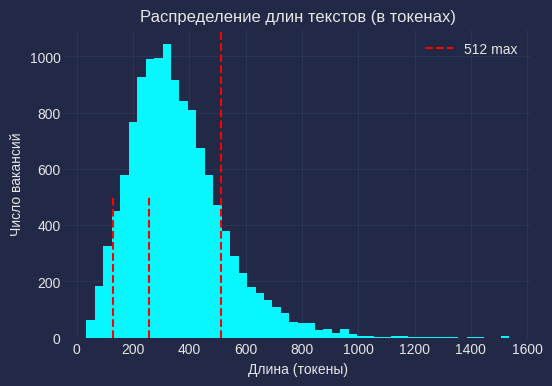

In [ ]:
# Считаем длины
lengths = train_df['full_text'].map(
    lambda t: len(tokenizer.tokenize(t))
)

# Доля >512
pct_long = (lengths > 512).mean() * 100
print(f"Длиннее 512 токенов: {pct_long:.1f}% строк")

# Гистограмма
plt.figure(figsize=(6,4))
plt.hist(lengths, bins=50)
plt.axvline(512, color='red', linestyle='--', label='512 max')
plt.vlines([128, 256], 0, 500, linestyles='--', colors='red')
plt.title("Распределение длин текстов (в токенах)")
plt.xlabel("Длина (токены)")
plt.ylabel("Число вакансий")
plt.legend()
plt.show()

**Вывод по графику:**
- Если условно ограничивать длину в 512 токенов, то мы потеряем информацию в 15% строк, что не прям фатально, но в дальнейшем я попробую более длинные модели.

In [ ]:
train_ds = datasets.Dataset.from_pandas(train_df[['full_text','log_salary_from']])
val_ds = datasets.Dataset.from_pandas(val_df[['full_text','log_salary_from']])

In [ ]:
def preprocess(batch):
    enc = tokenizer(batch['full_text'],
              padding='max_length',
              truncation=True,
              max_length=512)
    enc['labels'] = batch['log_salary_from']        # ключ labels ждёт Trainer
    return enc

In [ ]:
train_ds = train_ds.map(preprocess, batched=True, remove_columns=train_ds.column_names)
val_ds = val_ds.map(preprocess, batched=True, remove_columns=val_ds.column_names)

train_ds.set_format(type='torch')
val_ds.set_format(type='torch')

Map:   0%|          | 0/12500 [00:00<?, ? examples/s]

Map:   0%|          | 0/4167 [00:00<?, ? examples/s]

#### Обучение

In [ ]:
model_rubert_1 = AutoModelForSequenceClassification.from_pretrained(
            checkpoint, num_labels=1, problem_type='regression')

collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='pt')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
args = TrainingArguments(
    output_dir='rubert_reg',
    run_name='rubert_gpu_run',
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_strategy='epoch',
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type='linear',
    fp16=True,
    load_best_model_at_end=True,
    seed=42,
    report_to=['tensorboard'],
    disable_tqdm=False,
)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    return {'R² rubert-base-cased': r2_score(labels, logits.squeeze(-1))}

trainer = Trainer(model=model_rubert_1,
                  args=args,
                  train_dataset=train_ds,
                  eval_dataset=val_ds,
                  data_collator=collator,
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics)

trainer.train()

Epoch,Training Loss,Validation Loss,R² rubert-base-cased
1,0.932100,0.118714,0.697301
2,0.106000,0.108327,0.723782


TrainOutput(global_step=3126, training_loss=0.5190475717692213, metrics={'train_runtime': 2062.9427, 'train_samples_per_second': 12.119, 'train_steps_per_second': 1.515, 'total_flos': 6577717324800000.0, 'train_loss': 0.5190475717692213, 'epoch': 2.0})

#### Сохранение прогнозов на тестовой выборке

In [ ]:
test_2 = test.copy()

In [ ]:
test_2 = test_2.fillna('')
text_cols = ['title','location','company','skills','description']
test_2['full_text'] = test_2[text_cols].agg(' '.join, axis=1)

In [ ]:
# Переводим в HF‑Dataset и токенизируем используем ту же функцию preprocess, что и для train_ds
test_ds_2 = Dataset.from_pandas(test_2[['full_text']])
test_ds_2 = test_ds_2.map(
    lambda batch: tokenizer(
        batch['full_text'],
        padding='max_length',
        truncation=True,
        max_length=512
    ),
    batched=True,
    remove_columns=test_ds_2.column_names
).with_format('torch')

Map:   0%|          | 0/5556 [00:00<?, ? examples/s]

In [ ]:
# Получаем предсказания
pred_output_2 = trainer.predict(test_ds_2)
#    pred_output.predictions — это numpy array shape (N,1)
preds_2 = pred_output_2.predictions.squeeze(-1)

submission = pd.DataFrame({
    'index': range(len(preds_2)),
    'prediction': preds_2
})

# Сохраняем в файл
submission.to_csv('submission_2.csv', index=False)
print("saved submission_2.csv")

saved submission_2.csv


### Вариант с кросс-валидацией

In [ ]:
df_2 = train.copy()

In [ ]:
df_2 = df_2.fillna('')
df_2['full_text'] = df_2[txt_cols].agg(' '.join, axis=1)

In [ ]:
checkpoint = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
def preprocess(batch):
    enc = tokenizer(
        batch['full_text'],
        padding='max_length',
        truncation=True,
        max_length=512
    )
    enc['labels'] = batch['log_salary_from']
    return enc

In [ ]:
# K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
fold_scores = []

for fold, (tr_idx, va_idx) in enumerate(kf.split(df)):
    train_df = df.iloc[tr_idx].reset_index(drop=True)
    val_df = df.iloc[va_idx].reset_index(drop=True)

    # HF Datasets
    ds_tr = datasets.Dataset.from_pandas(train_df[['full_text','log_salary_from']])
    ds_va = datasets.Dataset.from_pandas(val_df  [['full_text','log_salary_from']])
    ds_tr = ds_tr.map(preprocess, batched=True, remove_columns=ds_tr.column_names)
    ds_va = ds_va.map(preprocess, batched=True, remove_columns=ds_va.column_names)
    ds_tr.set_format('torch')
    ds_va.set_format('torch')

    model = AutoModelForSequenceClassification.from_pretrained(
        checkpoint, num_labels=1, problem_type='regression'
    )

    args = TrainingArguments(
        output_dir=f'rubert_fold_{fold}',
        eval_strategy='epoch',
        save_strategy='no',
        logging_strategy='epoch',
        num_train_epochs=2,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        learning_rate=2e-5,
        weight_decay=0.01,
        warmup_ratio=0.1,
        lr_scheduler_type='linear',
        fp16=True,
        report_to=[],
        disable_tqdm=False
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=ds_tr,
        eval_dataset=ds_va,
        data_collator=DataCollatorWithPadding(tokenizer),
        tokenizer=tokenizer,
        compute_metrics=lambda p: {'r2': r2_score(p.label_ids, p.predictions.squeeze(-1))}
    )

    trainer.train()
    score = trainer.evaluate()['eval_r2']
    fold_scores.append(score)
    print(f'Fold {fold}: R² = {score:.4f}')

print(f'Average CV R²: {np.mean(fold_scores):.4f}')

Map:   0%|          | 0/13333 [00:00<?, ? examples/s]

Map:   0%|          | 0/3334 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,R2
1,0.804000,0.142283,0.630649
2,0.102700,0.108422,0.718548


Fold 0: R² = 0.7185


Map:   0%|          | 0/13333 [00:00<?, ? examples/s]

Map:   0%|          | 0/3334 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,R2
1,0.909600,0.134049,0.671668
2,0.102000,0.109991,0.730595


Fold 1: R² = 0.7306


Map:   0%|          | 0/13334 [00:00<?, ? examples/s]

Map:   0%|          | 0/3333 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,R2
1,0.901900,0.188795,0.538244


Fold 2: R² = 0.7261


Map:   0%|          | 0/13334 [00:00<?, ? examples/s]

Map:   0%|          | 0/3333 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,R2
1,0.932300,0.150390,0.611991
2,0.106300,0.106580,0.725046


Fold 3: R² = 0.7250


Map:   0%|          | 0/13334 [00:00<?, ? examples/s]

Map:   0%|          | 0/3333 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,R2
1,0.930500,0.125293,0.681164
2,0.105300,0.102882,0.738201


Fold 4: R² = 0.7382
Average CV R²: 0.7277


In [ ]:
# Финальная модель
full_ds = datasets.Dataset.from_pandas(df[['full_text','log_salary_from']])
full_ds = full_ds.map(preprocess, batched=True, remove_columns=full_ds.column_names)
full_ds.set_format('torch')

model_rubert_2 = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=1, problem_type='regression'
)

final_args = TrainingArguments(
    output_dir='rubert_reg',
    run_name='rubert_gpu_run_cv',
    eval_strategy='no',
    save_strategy='epoch',
    logging_strategy='steps',
    logging_steps=100,
    num_train_epochs=2,
    per_device_train_batch_size=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type='linear',
    fp16=True,
    report_to=[],
    disable_tqdm=False
)

final_trainer = Trainer(
    model=model_rubert_2,
    args=final_args,
    train_dataset=full_ds,
    data_collator=DataCollatorWithPadding(tokenizer),
    tokenizer=tokenizer
)

final_trainer.train()

Map:   0%|          | 0/16667 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,13.527200
200,0.528100
300,0.291400
400,0.227600
500,0.202900
600,0.188400
700,0.175900
800,0.168200
900,0.194800
1000,0.178100


TrainOutput(global_step=4168, training_loss=0.46365683504349897, metrics={'train_runtime': 2484.5386, 'train_samples_per_second': 13.417, 'train_steps_per_second': 1.678, 'total_flos': 8770465172195328.0, 'train_loss': 0.46365683504349897, 'epoch': 2.0})

**Лучший сабмит в соревновании**
- Данная попытка с кросс-валидацией и дообучением модели rubert от DeepPavlov показала наилучший результат из моих сабмитов. В целом, кросс-валидация помогла поднять сотые в R².
- На приблизительно таком же уровне находится дальнейшая модель на основе модели от VKAI, но кросс-валидация там проведена не была.

#### Сохранение прогнозов на тестовой выборке

In [ ]:
test_3 = test.copy()

In [ ]:
test_3 = test_3.fillna('')
text_cols = ['title','location','company','skills','description']
test_3['full_text'] = test_3[text_cols].agg(' '.join, axis=1)

In [ ]:
# Переводим в HF‑Dataset и токенизируем используем ту же функцию preprocess, что и для train_ds
test_ds_3 = Dataset.from_pandas(test_3[['full_text']])
test_ds_3 = test_ds_3.map(
    lambda batch: tokenizer(
        batch['full_text'],
        padding='max_length',
        truncation=True,
        max_length=512
    ),
    batched=True,
    remove_columns=test_ds_3.column_names
).with_format('torch')

Map:   0%|          | 0/5556 [00:00<?, ? examples/s]

In [ ]:
# Получаем предсказания
pred_output_3 = trainer.predict(test_ds_3)
#    pred_output.predictions — это numpy array shape (N,1)
preds_3 = pred_output_3.predictions.squeeze(-1)

submission = pd.DataFrame({
    'index': range(len(preds_3)),
    'prediction': preds_3
})

# Сохраняем в файл
submission.to_csv('submission_3.csv', index=False)
print("saved submission_3.csv")

saved submission_3.csv


## xlm-roberta-base от FacebookAI (без заморозки)

In [ ]:
df_1 = train.copy()

In [ ]:
df_1 = df_1.fillna('')
df_1['full_text'] = df_1[txt_cols].agg(' '.join, axis=1)

train_df, val_df = train_test_split(df_1, test_size=0.25, random_state=RANDOM_STATE)

In [ ]:
train_ds = datasets.Dataset.from_pandas(train_df[['full_text','log_salary_from']])
val_ds = datasets.Dataset.from_pandas(val_df[['full_text','log_salary_from']])

In [ ]:
checkpoint = "FacebookAI/xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Длиннее 512 токенов: 31.9% строк


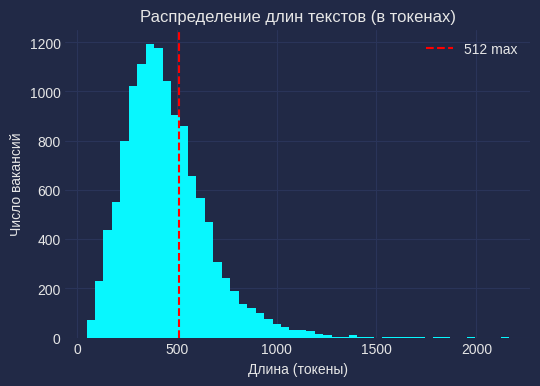

In [ ]:
# Считаем длины
lengths = train_df['full_text'].map(
    lambda t: len(tokenizer.tokenize(t))
)

# Доля >512
pct_long = (lengths > 512).mean() * 100
print(f"Длиннее 512 токенов: {pct_long:.1f}% строк")

# Гистограмма
plt.figure(figsize=(6,4))
plt.hist(lengths, bins=50)
plt.axvline(512, color='red', linestyle='--', label='512 max')
plt.vlines([128, 256], 0, 500, linestyles='--', colors='red')
plt.title("Распределение длин текстов (в токенах)")
plt.xlabel("Длина (токены)")
plt.ylabel("Число вакансий")
plt.legend()
plt.show()

In [ ]:
def preprocess(batch):
    enc = tokenizer(batch['full_text'],
              padding='max_length',
              truncation=True,
              max_length=512)
    enc['labels'] = batch['log_salary_from']        # ключ labels ждёт Trainer
    return enc

In [ ]:
train_ds = train_ds.map(preprocess, batched=True, remove_columns=train_ds.column_names)
val_ds   = val_ds.map(preprocess, batched=True, remove_columns=val_ds.column_names)

train_ds.set_format(type='torch')
val_ds.set_format(type='torch')

Map:   0%|          | 0/12500 [00:00<?, ? examples/s]

Map:   0%|          | 0/4167 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
            checkpoint, num_labels=1, problem_type='regression')

collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='pt')

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
args = TrainingArguments(
    output_dir='roberta_reg',
    run_name='roberta_gpu_run',
    eval_strategy = 'epoch',
    save_strategy = 'epoch',
    logging_strategy = 'steps',
    logging_steps = 50,
    eval_steps = 200,
    num_train_epochs = 3,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size  = 8,
    gradient_accumulation_steps = 2,
    learning_rate = 2e-5,
    weight_decay = 0.01,
    warmup_ratio = 0.1,
    lr_scheduler_type = 'cosine',
    fp16 = True,
    gradient_checkpointing = True,
    load_best_model_at_end = True,
    metric_for_best_model  = 'eval_loss',
    save_total_limit = 2,
    disable_tqdm = False,
    report_to = [],
    seed = 42,
)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    return {'R² xlm-roberta-base': r2_score(labels, logits.squeeze(-1))}

trainer = Trainer(model=model,
                  args=args,
                  train_dataset=train_ds,
                  eval_dataset=val_ds,
                  data_collator=collator,
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics)

trainer.train()

Epoch,Training Loss,Validation Loss,R² xlm-roberta-base
1,0.226600,0.176464,0.550074
2,0.168800,0.161080,0.589296
3,0.126800,0.178224,0.545582


TrainOutput(global_step=1173, training_loss=0.8584880755685479, metrics={'train_runtime': 9389.9837, 'train_samples_per_second': 3.994, 'train_steps_per_second': 0.125, 'total_flos': 9866575987200000.0, 'train_loss': 0.8584880755685479, 'epoch': 3.0})

#### Сохранение прогнозов на тестовой выборке

In [ ]:
test_3 = test.copy()

Подготовить тестовый DataFrame точно так же, как train/val

In [ ]:
test_3 = test_3.fillna('')
text_cols = ['title','location','company','skills','description']
test_3['full_text'] = test_3[text_cols].agg(' '.join, axis=1)

In [ ]:
# Переводим в HF‑Dataset и токенизируем используем ту же функцию preprocess, что и для train_ds
test_ds_3 = Dataset.from_pandas(test_3[['full_text']])
test_ds_3 = test_ds_3.map(
    lambda batch: tokenizer(
        batch['full_text'],
        padding='max_length',
        truncation=True,
        max_length=512
    ),
    batched=True,
    remove_columns=test_ds_3.column_names
).with_format('torch')

Map:   0%|          | 0/5556 [00:00<?, ? examples/s]

In [ ]:
# Получаем предсказания
pred_output_3 = trainer.predict(test_ds_3)
#    pred_output.predictions — это numpy array shape (N,1)
preds_3 = pred_output_3.predictions.squeeze(-1)

submission = pd.DataFrame({
    'index': range(len(preds_3)),
    'prediction': preds_3
})

# Сохраняем в файл
submission.to_csv('submission_3.csv', index=False)
print("saved submission.csv")

saved submission.csv


## RuModernBERT-base (без заморозки)

Тот пункт, в котором я решил опробовать более длинную модель, чтоб обрезать меньшее количество токенов в тех самых 15% строк.

### Первый вариант с максимальной длиной в 512

In [ ]:
df_4 = train.copy().fillna('')
txt_cols = ['title','location','company','skills','description']
df_4['full_text'] = df_4[txt_cols].agg(' '.join, axis=1)

train_df, val_df = train_test_split(df_4, test_size=0.25, random_state=RANDOM_STATE)

In [ ]:
checkpoint = 'deepvk/RuModernBERT-base'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def preprocess(batch):
    enc = tokenizer(batch['full_text'],
                    padding='max_length',
                    truncation=True,
                    max_length=512)
    enc['labels'] = batch['log_salary_from']
    return enc

Длиннее 512 токенов: 33.1% строк


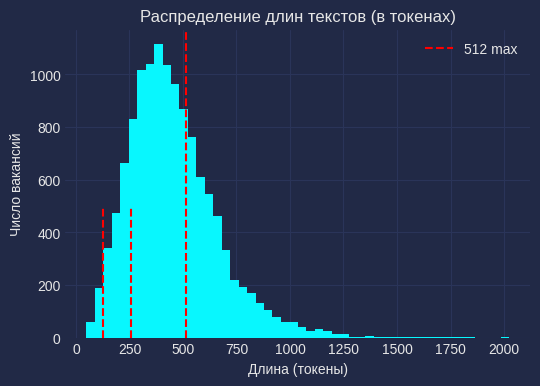

In [ ]:
# Считаем длины
lengths = train_df['full_text'].map(
    lambda t: len(tokenizer.tokenize(t))
)

# Доля >512
pct_long = (lengths > 512).mean() * 100
print(f"Длиннее 512 токенов: {pct_long:.1f}% строк")

# Гистограмма
plt.figure(figsize=(6,4))
plt.hist(lengths, bins=50)
plt.axvline(512, color='red', linestyle='--', label='512 max')
plt.vlines([128, 256], 0, 500, linestyles='--', colors='red')
plt.title("Распределение длин текстов (в токенах)")
plt.xlabel("Длина (токены)")
plt.ylabel("Число вакансий")
plt.legend()
plt.show()

In [ ]:
train_ds = datasets.Dataset.from_pandas(train_df[['full_text','log_salary_from']])
val_ds = datasets.Dataset.from_pandas(val_df[['full_text','log_salary_from']])

train_ds = train_ds.map(preprocess, batched=True, remove_columns=train_ds.column_names)
val_ds = val_ds.map(preprocess, batched=True, remove_columns=val_ds.column_names)

train_ds.set_format('torch')
val_ds.set_format('torch')

Map:   0%|          | 0/12500 [00:00<?, ? examples/s]

Map:   0%|          | 0/4167 [00:00<?, ? examples/s]

In [ ]:
model_rumodernbert_1 = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=1, problem_type='regression'
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at deepvk/RuModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
args = TrainingArguments(
    output_dir='rumod_bert',
    run_name='rumodernbert_gpu_run',
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_strategy='epoch',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type='linear',
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    seed=RANDOM_STATE,
    report_to=[],
    disable_tqdm=False
)

In [ ]:
trainer = Trainer(
    model=model_rumodernbert_1,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=DataCollatorWithPadding(tokenizer),
    tokenizer=tokenizer,
    compute_metrics=lambda p: {
        'r2': r2_score(p.label_ids, p.predictions.squeeze(-1))
    }
)

trainer.train()
print("RuModernBERT Val R²:", trainer.evaluate()['eval_r2'])

Epoch,Training Loss,Validation Loss,R2
1,0.453800,0.158128,0.596777
2,0.157700,0.240355,0.387096
3,0.107400,0.113239,0.711250


RuModernBERT Val R²: 0.7112501928024406


#### Сохранение прогнозов на тестовой выборке

In [ ]:
test_4 = test.copy()

In [ ]:
test_4 = test_4.fillna('')
text_cols = ['title','location','company','skills','description']
test_4['full_text'] = test_4[text_cols].agg(' '.join, axis=1)

In [ ]:
# Переводим в HF‑Dataset и токенизируем используем ту же функцию preprocess, что и для train_ds
test_ds_4 = Dataset.from_pandas(test_4[['full_text']])
test_ds_4 = test_ds_4.map(
    lambda batch: tokenizer(
        batch['full_text'],
        padding='max_length',
        truncation=True,
        max_length=512
    ),
    batched=True,
    remove_columns=test_ds_4.column_names
).with_format('torch')

Map:   0%|          | 0/5556 [00:00<?, ? examples/s]

In [ ]:
# Получаем предсказания
pred_output_4 = trainer.predict(test_ds_4)
#    pred_output.predictions — это numpy array shape (N,1)
preds_4 = pred_output_4.predictions.squeeze(-1)

submission = pd.DataFrame({
    'index': range(len(preds_4)),
    'prediction': preds_4
})

# Сохраняем в файл
submission.to_csv('submission_4.csv', index=False)
print("saved submission_4.csv")

saved submission_4.csv


### Второй вариант с максимальной длиной в 1024 (для теста на такой длине взял "длинную" модельку)

In [ ]:
df_5 = train.copy().fillna('')
txt_cols = ['title','location','company','skills','description']
df_5['full_text'] = df_5[txt_cols].agg(' '.join, axis=1)

train_df, val_df = train_test_split(df_5, test_size=0.25, random_state=RANDOM_STATE)

In [ ]:
checkpoint = 'deepvk/RuModernBERT-base'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def preprocess(batch):
    enc = tokenizer(batch['full_text'],
                    padding='max_length',
                    truncation=True,
                    max_length=1024)
    enc['labels'] = batch['log_salary_from']
    return enc

In [ ]:
train_ds = datasets.Dataset.from_pandas(train_df[['full_text','log_salary_from']])
val_ds = datasets.Dataset.from_pandas(val_df[['full_text','log_salary_from']])

train_ds = train_ds.map(preprocess, batched=True, remove_columns=train_ds.column_names)
val_ds = val_ds.map(preprocess, batched=True, remove_columns=val_ds.column_names)

train_ds.set_format('torch')
val_ds.set_format('torch')

Map:   0%|          | 0/12500 [00:00<?, ? examples/s]

Map:   0%|          | 0/4167 [00:00<?, ? examples/s]

In [ ]:
model_rumodernbert_2 = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=1, problem_type='regression'
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at deepvk/RuModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
args = TrainingArguments(
    output_dir='rumod_bert',
    run_name='rumodernbert_gpu_run',
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_strategy='epoch',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type='linear',
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    seed=RANDOM_STATE,
    report_to=[],
    disable_tqdm=False
)

In [ ]:
trainer = Trainer(
    model=model_rumodernbert_2,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=DataCollatorWithPadding(tokenizer),
    tokenizer=tokenizer,
    compute_metrics=lambda p: {
        'r2': r2_score(p.label_ids, p.predictions.squeeze(-1))
    }
)

trainer.train()
print("RuModernBERT Val R²:", trainer.evaluate()['eval_r2'])

Epoch,Training Loss,Validation Loss,R2
1,0.520200,0.160939,0.589608
2,0.145200,0.175433,0.552656
3,0.101900,0.109899,0.719772


RuModernBERT Val R²: 0.7197723397142262


**Результат модели** получился неплохим, но с ней стоит всё же поиграться и провести кросс-валидацию, так что это явно не лучший результат на этой модели.

#### Сохранение прогнозов на тестовой выборке

In [ ]:
test_5 = test.copy()

In [ ]:
test_5 = test_5.fillna('')
text_cols = ['title','location','company','skills','description']
test_5['full_text'] = test_5[text_cols].agg(' '.join, axis=1)

In [ ]:
# Переводим в HF‑Dataset и токенизируем используем ту же функцию preprocess, что и для train_ds
test_ds_5 = Dataset.from_pandas(test_5[['full_text']])
test_ds_5 = test_ds_5.map(
    lambda batch: tokenizer(
        batch['full_text'],
        padding='max_length',
        truncation=True,
        max_length=1024
    ),
    batched=True,
    remove_columns=test_ds_5.column_names
).with_format('torch')

Map:   0%|          | 0/5556 [00:00<?, ? examples/s]

In [ ]:
# Получаем предсказания
pred_output_5 = trainer.predict(test_ds_5)
#    pred_output.predictions — это numpy array shape (N,1)
preds_5 = pred_output_5.predictions.squeeze(-1)

submission = pd.DataFrame({
    'index': range(len(preds_5)),
    'prediction': preds_5
})

# Сохраняем в файл
submission.to_csv('submission_5.csv', index=False)
print("saved submission_5.csv")

saved submission_5.csv


## Заключение (Outro)

### Анализ того, что пробовал  

- **Самописный Tiny‑Transformer**  
  > Быстрый в обучении, работает на CPU или одной GPU без сторонних весов.  
  > Дал +0.05 R² к линейному бейзлайну, но уровень контекста ограничен — видит лишь 128 токенов.  

- **TF‑IDF + Ridge**  
  > Контрольный вариант «с нуля»: легко деплоится, не требует GPU, сам по себе легкий вариант, но вряд-ли применителен.  
  > Самая низкая метрика.  

- **RuBERT (fine‑tune, без CV)**  
  > Полный fine‑tune всех слоёв на нашем корпусе (2 эпохы, batch = 16).  
  > Уже через час тренировки обошёл Tiny‑Transformer по метрике R².  

- **RuBERT (fine‑tune, 5‑fold CV)**  
  > Запустил 5 фолдов, усреднил веса; стабилизировал результат и снял эффект «удачного сплита».  
  > Лучшая валидная метрика: +R² к однопроходному RuBERT. Цена — условные ×5 времени обучения.  

- **RuRoberta‑Large (fine‑tune)**  
  > Пытался получить ещё прирост за счёт более мощной архитектуры.  
  > С batch_size до 4 и шагом обучения 1e‑5 прирост метрики оказался символическим.  

- **ModernRuBERT (fine‑tune, 512 ток.)**  
  > Новая токенизация, читает почти весь description целиком.  
  > Чуть лучше RuRoberta, но LR плавать сложнее, а обучение вдвое дольше.  

- **ModernRuBERT (fine‑tune, 1024 ток.)**  
  > Максимальный контекст, batch_size = 1, нужно grad‑accum.  
  > Метрика ≈ как у варианта 512, хотя повышение всё же почти 0.1, однако время обучение увеличивается в x раз.  

### Анализ причин, что пошло (или могло пойти) не так  

- Проблемы с использованием TPU и всех предоставляемых ядер на Kaggle: возникла проблема того, что бесплатные 20 часов мощностей на Kaggle с TPU падает при попытке параллелизма - в целом, я в конечном итоге этот вопрос и не решил.
- Отсутствие достаточно опыта и глубоких теоретических знаний: возникали определённые моменты, в которых было недостаточно опыта в таких работах, чтобы корретно провести эксперимент или же придумать интересный подход для решения задачи.
- Возможно, неоптимальный подбор гиперпараметров: в целом, это относится к прошлому пункту, так что особо расписывать пункт не буду.
- Иные варианты предобработки: в целом, я бы ещё поэксперементировал с вариантами преодобработки текста - думаю, что есть ещё более интересные и полезные подходы, которые повысят метрику, та же колонка `experience_from` не была задействована, а могла бы и повысить результаты.

### Анализ применимости решения в бизнес‑процессах  

- **Автооценка зарплаты** — эндпоинт `/predict_salary` принимает вакансию, возвращает диапазон; сокращает цикл согласования оффера.  
- **Автоматический грейдинг** — mean‑embedding → k‑means → метка грейда; упрощает классификацию позиций HR‑специалистом.  
- **Поиск похожих вакансий** — косинус pooled‑эмбеддингов выдаёт релевантнее, чем ключевые слова; улучшает внутренние рекомендации и cross‑sell.  
- **HR‑аналитика рынка** — раз в сутки скрапим внешние борды, пропускаем через модель → видим тренд зарплат до отчётов аналитических агентств.  

Однако, важно то, как эти модели будут вести себя в продакшене, ибо важны скорость, применимость на новых получаемых данных и множество других факторов - именно поэтому это всё лишь теоретическая применимость.

### Итоговый вывод  

Лучший результат дала схема **RuBERT с 5‑fold CV** — оптимальный баланс точности и ресурсов. Tiny‑Transformer остаётся лёгким fallback без внешних весов, TF‑IDF + Ridge — мгновенный POC. Дальше теоретически можно попробовать:  
1. Расширить корпус (StackJobs + HH) и прогнать повторную валидацию.  
2. Смешать текстовые эмбеддинги с числовыми фичами (город, опыт, тип занятости).  
3. Экспортировать финальный чек‑пойнт в TorchScript/ONNX, завернуть в gRPC‑сервис.